# Test ellipse fit

## Imports

In [16]:
# Python standard library
import sys
import csv
import os

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [17]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_9/'
file_index = '2'
filtered = False

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events' + filtered*'filtered' + '.json'

In [18]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

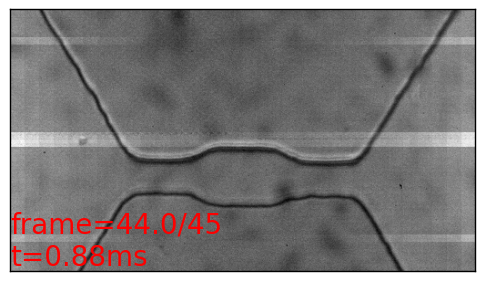

In [19]:
template_index = 1200

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.01249902  0.99992188]


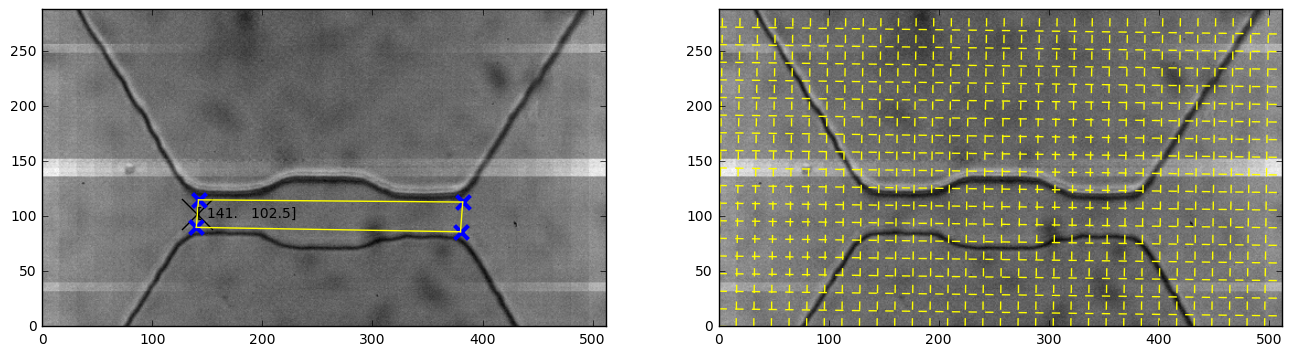

In [20]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)
c0 = [142, 115]
c1 = [140, 90]
c2 = [380, 86] 
c3 = [382, 113]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Define plotting functions

In [21]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()
    


## Define ellipse fitting functions

In [51]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

preprocessing_steps = []
def preprocess_fit_ellipse(raw_frame, raw_template_frame, detection, debug = 'none'):

    
    
    
    # Refresh list
    del preprocessing_steps[:]

    

    
    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, raw_frame)
        
        
    #################################
    # Crop
    #################################
    
    crop_distance = 30
    
    preprocessing_steps.append(['crop'] + [crop_distance])

    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    template_frame = crop_frame(template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    if debug == 'all':
        print 'crop'
        plot_all(processed_frame, frame)


    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(processed_frame - template_frame)


    if debug == 'all':
        print 'negative'
        plot_all(processed_frame, frame)




    #################################
    # Blur
    #################################


    blur_kernel = (25,25)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)





    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)






    #################################
    # Threshold
    #################################

    threshold = .3
    
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    if debug == 'all':
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)




    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)




    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)

    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)


    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)

        
        
        
        
    
 


    ###################################
    # Fit ellipse
    ###################################


    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[1], cell_pixels[0])

    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = oi.get_ellipse_center(ellipse, offset = (detection._px - crop_distance, detection._py - crop_distance))

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

    
    
    if debug != 'none':
        # Create perimeter line
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

        # Turn pixels green
        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame

        # Begin plot
        fig, axes = plt.subplots(1,3,figsize = (12,3))
        
        
        # Axes 0
        plt.sca(axes[0])
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])

        
        # Axes 1
        plt.sca(axes[1])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        #plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', lw = 5, color = 'red', s = 50)
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        
        # Axes 2
        plt.sca(axes[2])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'red', lw = 3, s = 20)
        
        
        ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
        ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]

        
        ax0 = ellipse_center[0]
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_center[1]
        ay1 = ay0 + ellipse_axis_a[1]
        
        bx0 = ellipse_center[0]
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_center[1]
        by1 = by0 + ellipse_axis_b[1]
        
        plt.plot([ax0, ax1], [ay0, ay1], lw = 3, c = 'red')
        plt.plot([bx0, bx1], [by0, by1], lw = 3, c = 'red')
        
        plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'red', size = 20, ha = 'left', va = 'bottom')
        plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'red', size = 20, ha = 'left', va = 'bottom')
        
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        
        
        plt.show()

## Find event to test fit on

In [49]:
oi_index = 2
oi_event = oi_events[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf).to_html5_video())

copy


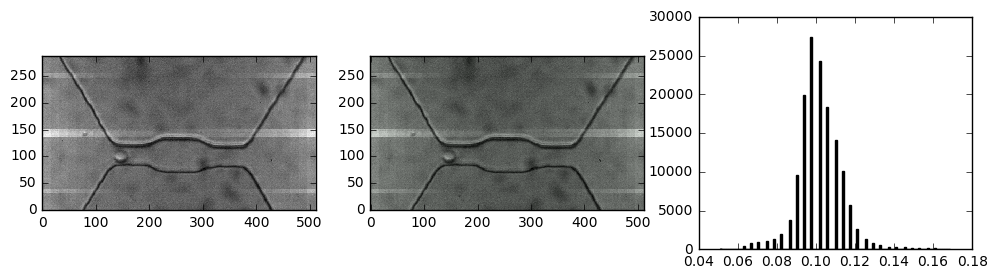

crop


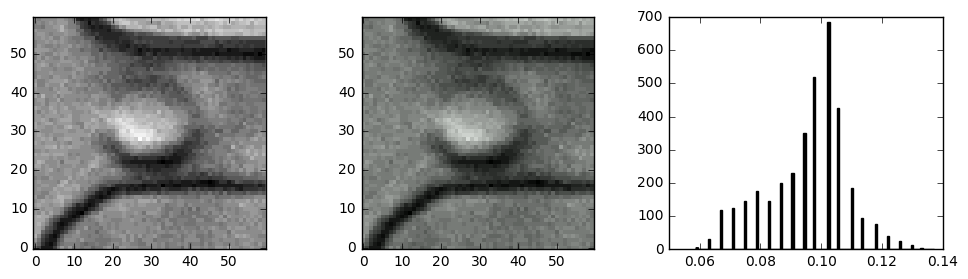

negative


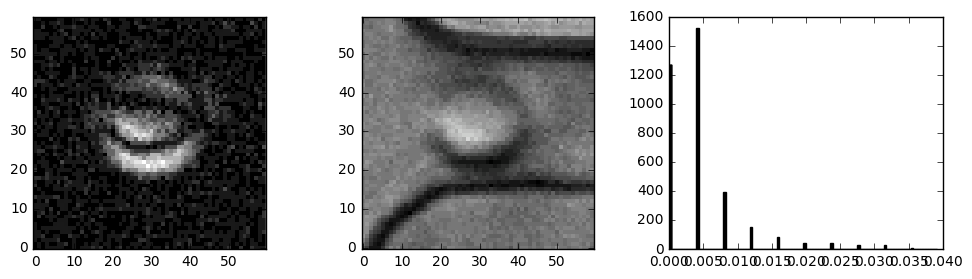

gaussian blur


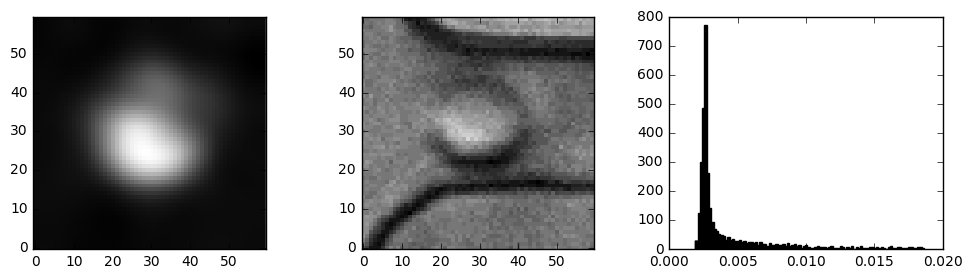

rescale


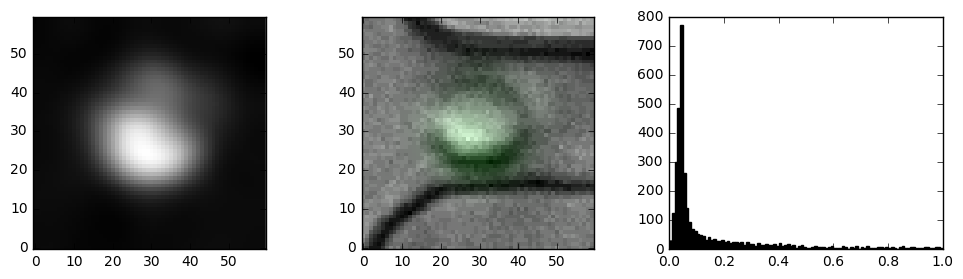

threshold


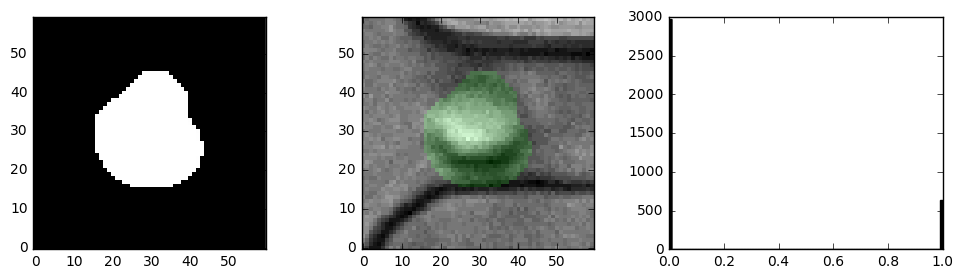

erode subtraction


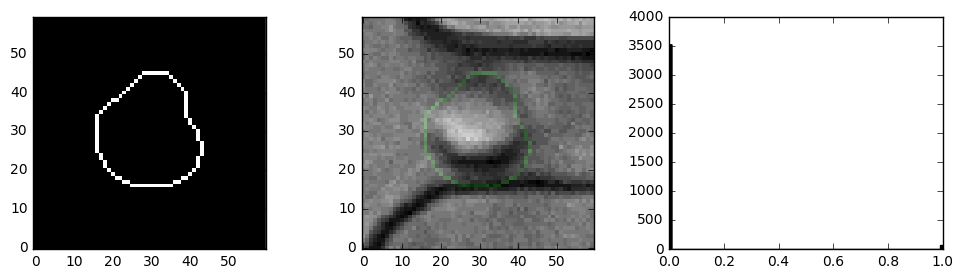

fill holes


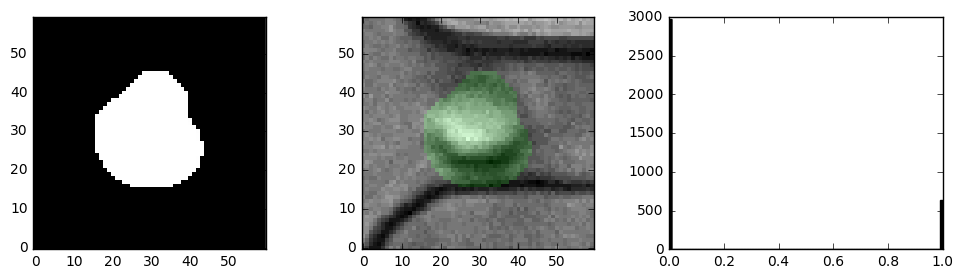

cluster


In [ ]:
xs = oi_event.get_px()
ys = oi_event.get_py()

xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)

xcs = oi_stage.pixels_to_meters(xcs)


xc_left = 0
xc_right = 15

for j, detection in enumerate(oi_event._detections):
    
    if xcs[j] >= xc_left and xcs[j] <= xc_right:
    
    
    
        # Get raw frame
        raw_frame = oi_vid.get_frame(detection._tf)


        preprocess_fit_ellipse(raw_frame, template_frame, detection, debug = 'all')